In [1]:
UPDATE = "asynchronous"
DIRECTORY = "../models/random_nk3"
NUM_RUNS = 1
DEBUG = True
row_wise_average = True

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from sdmarkov.basins import get_node_average_values
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff, get_dkl
from sdmarkov.transition_matrix import get_transition_matrix, get_uniform_matrix


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["rmsd"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    percolated_bnet = primes2bnet(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)

    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tsd_inf = nsquare(Tsd, 20, DEBUG=DEBUG)
    Tsd_inf_expanded = expand_matrix(Tsd_inf, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)
    Tnull_inf = nsquare(Tnull, 20, DEBUG=DEBUG)
    Tnull_inf_expanded = expand_matrix(Tnull_inf, null_indices, DEBUG=DEBUG)

    Tref = get_uniform_matrix(2**(len(percolated_primes)))

    # Get node average values
    T_node_average_values = get_node_average_values(T_inf, DEBUG=DEBUG)
    Tsd_node_average_values = get_node_average_values(Tsd_inf_expanded, DEBUG=DEBUG)
    Tnull_node_average_values = get_node_average_values(Tnull_inf_expanded, DEBUG=DEBUG)
    ref_node_average_values = get_node_average_values(Tref, DEBUG=DEBUG)

    # Get comparison results
    data["rmsd"]["Tsd"] = get_rms_diff(T_node_average_values, Tsd_node_average_values, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    data["rmsd"]["Tnull"] = get_rms_diff(T_node_average_values, Tnull_node_average_values, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    data["rmsd"]["ref"] = get_rms_diff(T_node_average_values, ref_node_average_values, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)

    # Get basin ratios for the random matrix and get comparison results
    data["rmsd"]["Trandom"] = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        Trandom_inf = nsquare(Trandom, 20, DEBUG=DEBUG)
        Trandom_inf_expanded = expand_matrix(Trandom_inf, random_indices, DEBUG=DEBUG)

        Trandom_node_average_values = get_node_average_values(Trandom_inf_expanded, DEBUG=DEBUG)

        data["rmsd"]["Trandom"].append(get_rms_diff(T_node_average_values, Trandom_node_average_values, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG))
    
    return data

In [3]:
all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["rmsd"]["Tsd"],
          np.mean(all_data[bnet]["rmsd"]["Trandom"]),
          all_data[bnet]["rmsd"]["Tnull"],
          all_data[bnet]["rmsd"]["ref"],
          )

n010_000.bnet 0.11748355580895091 0.15021099244436878 0.15076390645874893 0.35032806837406333
n010_001.bnet 0.03314563036811941 0.11431234092332927 0.11943258379420271 0.2334181858364225
n010_002.bnet 0.0 0.0 0.0 0.5
n010_003.bnet 0.0 0.0 0.0 0.5
n010_004.bnet 0.029055349959744365 0.12777381063829985 0.13066931602629592 0.39542468417884
n010_005.bnet 0.2154063215951727 0.2154063215951727 0.2154063215951727 0.2154063215951727
n010_006.bnet 0.02708608193875193 0.07187532580408441 0.0641543402573029 0.42322072181528375
n010_007.bnet 0.008048006239471921 0.003553662495104093 0.005875262714779811 0.4423630873986149
n010_008.bnet 0.11775264121708982 0.2148494654952165 0.21553321612499166 0.22383884665725637
n010_009.bnet 0.2515701821621405 0.31170907196873465 0.3120888984268606 0.3361977093439348
n010_010.bnet
n010_011.bnet 0.05011519695566268 0.2848354292718597 0.2872072308354224 0.3014875328591959
n010_012.bnet 0.0 0.0 0.0 0.5
n010_013.bnet 0.0018042195912175742 0.10837942609844772 0.12609

In [5]:
def plot_rmsd(rmsd):

    plt.figure(figsize=(5, 6))

    plt.hist(rmsd, bins=10, color='blue', alpha=0.7)
    plt.title('RMSD Histogram')
    plt.xlabel('RMSD')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 50)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

0.04776194539687951 0.07431215387592224


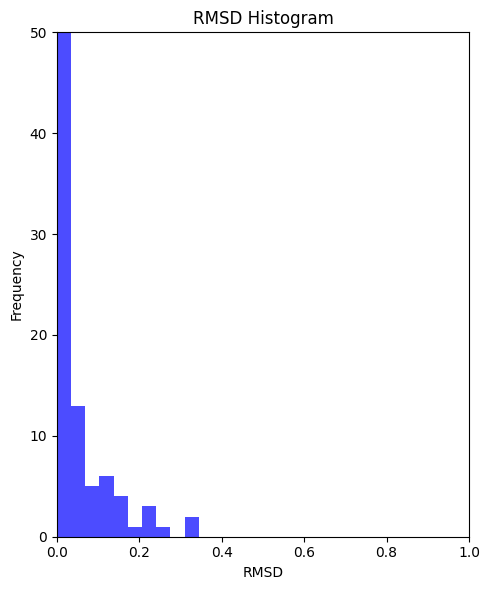

In [6]:
rmsd = []
dkl = []
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        continue
    rmsd.append(all_data[bnet]["rmsd"]["Tsd"])

print(np.mean(rmsd), np.std(rmsd))

plot_rmsd(rmsd)